In [1]:
!pip install imutils

In [2]:
import numpy as np
import cv2
import imutils
import pprint
from skimage.io import imread
from sklearn.cluster import KMeans
from collections import Counter
from matplotlib import pyplot as plt
from skimage.filters import threshold_otsu

## Section Two.1 : Function to Extract Skin Color

The ***extractSkin*** function takes an 8 bit 3 channel image in the BGR colorspace (as mentioned in the article this is how OpenCV reads color images) and returns the extracted image in same colorspace. 

The function works by using the** HSV colorspace** and uses thresholding (Thresholding is a process of filtering out pixel based on specified thresdhold parameter) to extracts pixel that corresponds to the skin color range,




In [3]:
def extractSkin(image):
  # Taking a copy of the image
    img =  image.copy()
    # Converting from BGR Colours Space to HSV
    img =  cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Defining HSV Threadholds
    lower_threshold = np.array([0, 48, 80], dtype=np.uint8)
    upper_threshold = np.array([20, 255, 255], dtype=np.uint8)

    # Single Channel mask,denoting presence of colours in the about threshold
    skinMask = cv2.inRange(img,
                           lower_threshold,
                           upper_threshold)

    # Cleaning up mask using Gaussian Filter
    skinMask = cv2.GaussianBlur(skinMask,(3,3),0)

    # Extracting skin from the threshold mask
    skin  =  cv2.bitwise_and(img,
                             img,
                             mask=skinMask)

    # Return the Skin image
    return cv2.cvtColor(skin,
                        cv2.COLOR_HSV2BGR)


## Section Two.2 :  Function to remove black pixels from extracted image

The ***removeBlack*** function is more sort of the utility function to remove out the black pixel from the skin extracted. Since OpenCV by default doesn't handle transparent images and replaces those with zeros(black in color word).

This function is useful when thresholding is used in the image.

In [4]:
def removeBlack(estimator_labels, estimator_cluster):
  
  # Check for black
    hasBlack = False

    # Get the total number of occurance for each color
    occurance_counter = Counter(estimator_labels)


    # Quick lambda function to compare to lists
    compare = lambda x, y: Counter(x) == Counter(y)
   
  # Loop through the most common occuring color
    for x in occurance_counter.most_common(len(estimator_cluster)):

    # Quick List comprehension to convert each of RBG Numbers to int
        color = [int(i) for i in estimator_cluster[x[0]].tolist() ]
    
  
    
        # Check if the color is [0,0,0] that if it is black 
        if compare(color , [0,0,0]) == True:
            # delete the occurance
            del occurance_counter[x[0]]
            # remove the cluster 
            hasBlack = True
            estimator_cluster = np.delete(estimator_cluster,x[0],0)
            break
      
    return (occurance_counter,
            estimator_cluster,
            hasBlack)

## Section Two.3 : Extract Colour Information

The ***getColorInfomation*** function does all the heavy lifiting to make sense of prediction that came from the clustering.

Taking the prediction labels (***estimator_labels***) and the cluster centroids(***estimator_cluster***) as the input and returns an array of dictionaries of the extracted colours.

The function also takes an optional parameter (***hasThresholding***) to indicate whether a mask was used. This passed from the ***extractDominantColor*** function


In [5]:
def getColorInformation(estimator_labels,
                        estimator_cluster,
                        hasThresholding=False):
  
    # Variable to keep count of the occurance of each color predicted
    occurance_counter = None

    # Output list variable to return
    colorInformation = []

    #Check for Black
    hasBlack = False
  
    # If a mask has be applied, remove th black
    if hasThresholding == True:
        occurance, cluster, black = removeBlack(estimator_labels, estimator_cluster)
        occurance_counter =  occurance
        estimator_cluster = cluster
        hasBlack = black
    
    else:
        occurance_counter = Counter(estimator_labels)

    # Get the total sum of all the predicted occurances
    totalOccurance = sum(occurance_counter.values()) 


    # Loop through all the predicted colors
    for x in occurance_counter.most_common(len(estimator_cluster)):
    
        index = (int(x[0]))

        # Quick fix for index out of bound when there is no threshold
        index =  (index-1) if ((hasThresholding & hasBlack) & (int(index) != 0)) else index

        # Get the color number into a list
        color = estimator_cluster[index].tolist()

        # Get the percentage of each color
        color_percentage= (x[1]/totalOccurance)

        #make the dictionay of the information
        colorInfo = {"cluster_index":index ,
                     "color": color , 
                     "color_percentage" : color_percentage }

        # Add the dictionary to the list
        colorInformation.append(colorInfo)
    
      
    return colorInformation 

## Section Two.4 : Putting it All together

The ***extractDominantColor*** is the function that call the above function to output the information.

The function take an 8 bit 3 channel BGR image as the input , the number of colors to be extracted. This does all the super heavy lifting by sparkling some magic power of machine learning.


As mention in the article , An unsupervised clustering algorithm, ***KMeans Clustering*** is used to cluster the pixel data based on their RGB values.


The function also takes an optional parameter (***hasThresholding***) to indicate whether a thresholding mask was used. This passed to the ***getColorInformation*** function




In [6]:
def extractDominantColor(image,
                         number_of_colors=2,
                         hasThresholding=False):
  
    # Quick Fix Increase cluster counter to neglect the black(Read Article) 
    if hasThresholding == True:
        number_of_colors +=1
  
    # Taking Copy of the image
    img = image.copy()

    # Convert Image into RGB Colours Space
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Reshape Image
    img = img.reshape((img.shape[0] * img.shape[1]), 3)

    #Initiate KMeans Object
    estimator = KMeans(n_clusters=number_of_colors, 
                       random_state=0)

    # Fit the image
    estimator.fit(img)

    # Get Colour Information
    colorInformation = getColorInformation(estimator.labels_,
                                           estimator.cluster_centers_,
                                           hasThresholding)
    return colorInformation

## Section Two.4.1 : Putting it All together: Making a Visually Representation

The ***plotColorBar*** function gives a visually representation of the extracted color information. 

Taking the color information (***colorInformation***) as input  and returns
 ***500x100 8 bit 3 channel BGR colorspace image***

In [7]:
def plotColorBar(colorInformation):
    
    #Create a 500x100 black image
    color_bar = np.zeros((100, 500, 3), dtype="uint8")

    top_x = 0

    for x in colorInformation:    
        bottom_x = top_x + (x["color_percentage"] * color_bar.shape[1])

        color = tuple(map(int,(x['color'])))

        cv2.rectangle(color_bar , (int(top_x), 0) , (int(bottom_x), color_bar.shape[0]), color, -1)
        top_x = bottom_x
        
    return color_bar

In [8]:
#Minha implementação
def prety_print_data(color_info):
    
    for x in color_info:
        print(pprint.pformat(x))
        print()
        
def mergex_mask_rgb(mask, img):
    
    result = img.copy()
    
    result[:, :, 0] = mask * img[:, :, 0]
    result[:, :, 1] = mask * img[:, :, 1]
    result[:, :, 2] = mask * img[:, :, 2]
    
    return result

def plot_images(img):
    
    plt.figure(figsize = (15, 10))
    plt.imshow(img)
    plt.show()
    
def binary_image_with_otsu(image):
    
    thresh = threshold_otsu(image)
    return image > thresh

def segment_mask_face(image):
    
    #hsv
    img_HSV = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    HSV_mask = cv2.inRange(img_HSV, 
                           (0, 15, 0), 
                           (17, 170,255)) 
    
    HSV_mask = cv2.morphologyEx(HSV_mask, 
                                cv2.MORPH_OPEN, 
                                np.ones((3, 3), np.uint8))

    #YCbCr 
    img_YCrCb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    YCrCb_mask = cv2.inRange(img_YCrCb,
                             (0, 135, 85), 
                             (255, 180, 135)) 
    
    YCrCb_mask = cv2.morphologyEx(YCrCb_mask,
                                  cv2.MORPH_OPEN,
                                  np.ones((3, 3), np.uint8))

    #YCbCr + hsv
    global_mask=cv2.bitwise_and(YCrCb_mask, HSV_mask)
    global_mask=cv2.medianBlur(global_mask, 3)
    global_mask = cv2.morphologyEx(global_mask, 
                                   cv2.MORPH_OPEN, 
                                   np.ones((4, 4), np.uint8))

    return cv2.bitwise_not(global_mask)

In [42]:
#Minha implementação
image_rgb = imread('images/maria.jpg')
image_rgb = imutils.resize(image_rgb, width=250)
image_bgr = image_rgb[:, :, ::-1]

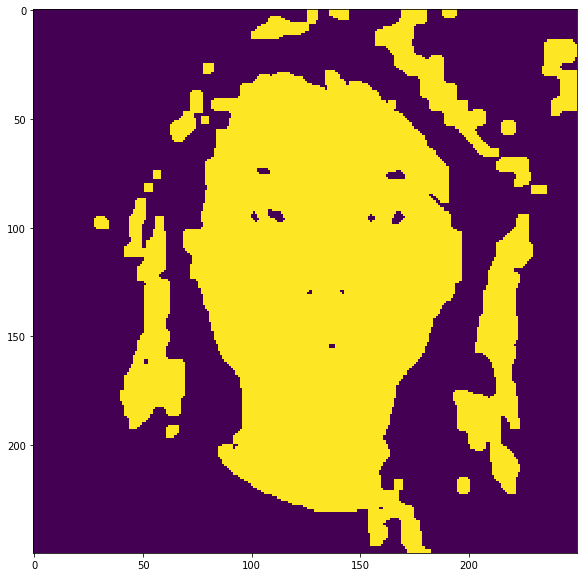

In [43]:
#Minha implementação
result_mask = segment_mask_face(image_bgr)
result_mask = binary_image_with_otsu(result_mask)
result_mask = np.invert(result_mask)
plot_images(result_mask)

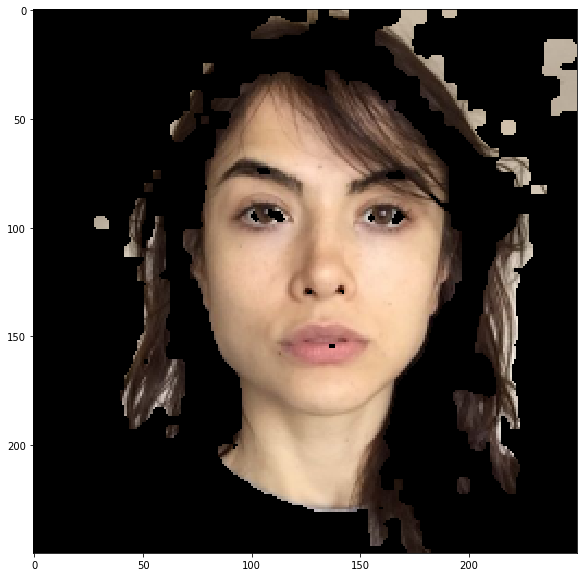

In [44]:
#Minha implementação
result_mergex_skin = mergex_mask_rgb(result_mask, image_rgb)
plot_images(result_mergex_skin)

In [45]:
# Apply Skin Mask
skin_originl = extractSkin(image_bgr) # Original
skin = result_mergex_skin[:,:,::-1] #Minha implementação

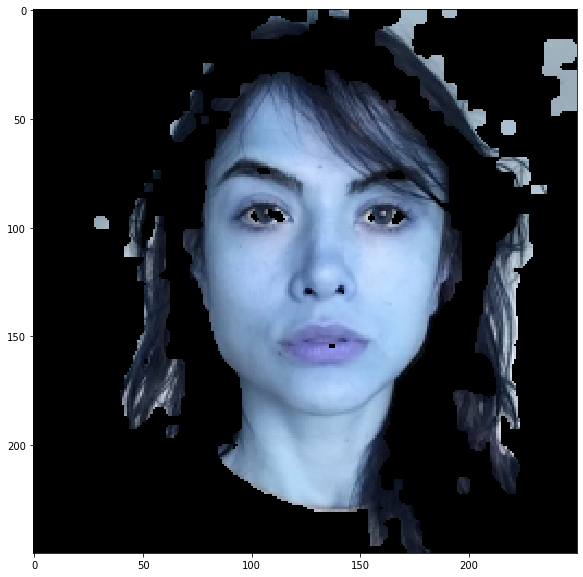

In [46]:
plot_images(skin)

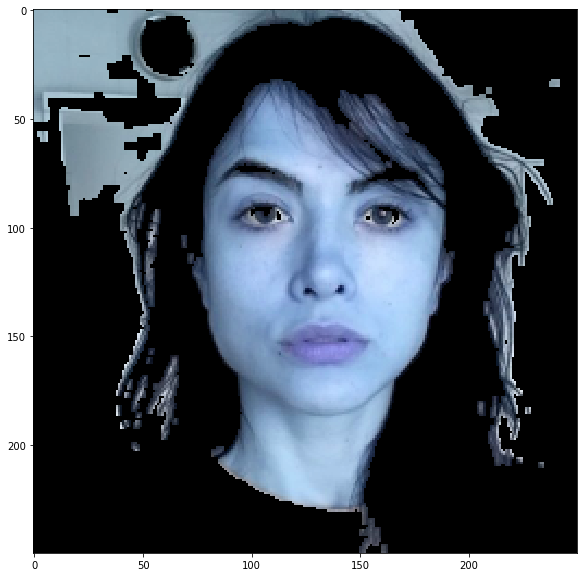

In [47]:
plot_images(skin_originl)

In [51]:
# Find the dominant color. Default is 1 , 
#pass the parameter 'number_of_colors=N' where N is the specified number of colors 
dominantColors = extractDominantColor(skin, 
                                      number_of_colors=3, 
                                      hasThresholding=True)

colour_bar = plotColorBar(dominantColors)

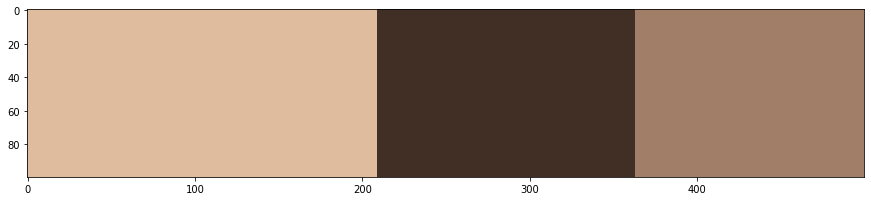

In [52]:
plot_images(colour_bar)

In [53]:
prety_print_data(dominantColors)

{'cluster_index': 2,
 'color': [224.86803370217257, 188.42554055426555, 158.87310932902614],
 'color_percentage': 0.41873301630434784}

{'cluster_index': 1,
 'color': [65.84802096262447, 47.19500758516056, 37.72390015170323],
 'color_percentage': 0.3078719429347826}

{'cluster_index': 0,
 'color': [160.5769051684084, 126.46841533447048, 104.23917429768183],
 'color_percentage': 0.27339504076086957}

